(50000, 784)


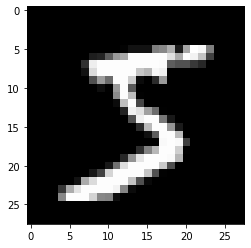

In [4]:

from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

###############################################################################
# 이 데이터셋은 numpy 배열 포맷이고, 데이터를 직렬화하기 위한
# python 전용 포맷 pickle 을 이용하여 저장되어 있습니다.

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

###############################################################################
# 각 이미지는 28 x 28 형태 이고, 784 (=28x28) 크기를 가진 하나의 행으로 저장되어 있습니다.
# 하나를 살펴 봅시다; 먼저 우리는 이 이미지를 2d로 재구성해야 합니다.

from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

In [59]:
import torch

x_train, y_train, x_test, y_test = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

###############################################################################
# PyTorch의 기울기를 자동으로 계산해주는 기능 덕분에, Python 표준 함수
# (또는 호출 가능한 객체)를 모델로 사용할 수 있습니다!
# 그러므로 간단한 선형 모델을 만들기 위해서 단순한 행렬 곱셈과 브로드캐스트(broadcast)
# 덧셈을 사용하여 보겠습니다. 또한, 우리는 활성화 함수(activation function)가 필요하므로,
# `log_softmax` 를 구현하고 사용할 것입니다.
# PyTorch에서 많은 사전 구현된 손실 함수(loss function), 활성화 함수들이 제공되지만,
# 일반적인 python을 사용하여 자신만의 함수를 쉽게 작성할 수 있음을 기억해주세요.
# PyTorch는 심지어 여러분의 함수를 위해서 빠른 GPU 또는 벡터화된 CPU 코드를 만들어줄 것입니다.

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

###############################################################################
# 위에서, ``@`` 기호는 점곱(dot product) 연산을 나타냅니다.
# 우리는 하나의 배치(batch) 데이터(이 경우에는 64개의 이미지들)에 대하여 함수를 호출할 것입니다.
# 이것은 하나의 *포워드 전달(forward pass)* 입니다. 이 단계에서 우리는 무작위(random) 가중치로
# 시작했기 때문에 우리의 예측이 무작위 예측보다 전혀 나은 점이 없을 것입니다.

bs = 64  # 배치 사이즈
xb = x_train[0:bs]  # x로부터 미니배치(mini-batch) 추출
print("xb.shape = ", xb.shape)
preds = model(xb)  # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)
xb.shape =  torch.Size([64, 784])
tensor([-2.3595, -2.0986, -2.2898, -2.2828, -2.3509, -2.4419, -2.0970, -2.0869,
        -2.3420, -2.9131], grad_fn=<SelectBackward>) torch.Size([64, 10])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [60]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3733, grad_fn=<NegBackward>)


In [61]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
print(accuracy(preds, yb))


tensor(0.0781)


In [62]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

#훈련 이후에는 결과가 1이다.. 다 맞춘다는 얘기지!


tensor(0.0825, grad_fn=<NegBackward>) tensor(1.)


# 이제 위의 내용들을 torch.nn 모듈을 이용해서 바꿔보자

In [98]:
# 이 부분은 내가 이런저런 자료를 참고해서 복합적으로 짜본 것이다.
# 따라서, 통일된 양식이 아닌점을 참고해주시길! 

from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

# step1) 데이터 준비
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

test_ds = TensorDataset(x_test, y_test)
test_dl = DataLoader(test_ds, batch_size=bs)


# step2) neural net 구성
class DNN(nn.Module):
  def __init__(self, input_size = 784, num_classes = 10):
    super(DNN, self).__init__()

    self.DNN = nn.Sequential(
        # 1st
        nn.Linear(input_size, 64),
        nn.ReLU(),
        
        # 2rd
        nn.Linear(64, 64),
        nn.ReLU(),

        # # 3rd
        # nn.Linear(64, 32),
        # nn.ReLU(),

        # # 4th
        # nn.Linear(32, 16),
        # nn.ReLU(),

        # 5th
        nn.Linear(64, num_classes),
    )

  def forward(self, x):
    y_  = x.view(x.size(0),-1)
    y_pred = self.DNN(y_)
    return y_pred


# step3) loss, optimizer, lr 구성
model = DNN()
lr = 1e-2
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# 참고로 성능을 위한 accuracy function도 만들었다.

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [100]:
# step4) 학습
all_loss = []
plot_every = 200
total_loss = 0

epochs = 11
step = 0

for epoch in range(epochs):
  for xb, yb in train_dl:
      y_pred = model(xb) #forward
      loss = loss_fn(y_pred, yb) # loss 계산

      optimizer.zero_grad() #제로로 바꿔주기
      loss.backward() #back-propagation 계산하기
      optimizer.step()

      # 학습을 출력
      if step % 500 == 499:
        print("step: {}, loss = {}".format(step+1, loss.item()))

      # loss 부분을 저장
      if (step+1) % 200 == 0:
        all_loss.append(total_loss / plot_every)
        total_loss = 0
      total_loss += loss.item()

      # 테스트가 잘되는 지 중간마다 출력

      if step % 2000 == 1999:
          model.eval()
          with torch.no_grad(): # test로 인한 gradient 계산은 ㄴㄴ
            acc = 0
            for xb, yb in test_dl:
              y_pred = model(xb)
              loss = loss_fn(y_pred, yb)
              acc += accuracy(y_pred, yb)
            print("*" * 46)
            print('Step: {}, Loss: {}, test accuracy: {} %'.format(step+1, loss.item(), acc/10000*bs))
            print("*" * 46)
      step += 1

# step5) 결과를 시각화 해보자.

plt.plot(all_loss)

'''
실험결과 --> 학습률을 크게하고, Hidden layer의 층을 줄일 수록 높은 성과가 나온다.

'''

SyntaxError: ignored